# Лабораторная работа №4
## $R_{N} | d_{i} | D_{max}$

**Задача**: Задача поиска расписания, минимизирующего максимальное отклонение
времен завершения работ от директивных сроков на $N$ параллельных
машинах.

Реализовать алгоритм решения с помощью библиотеки Pyomo и собственный жадный алгоритм для решения данной задачи, создать универсальный формат задания задачи.

In [143]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import networkx as nx
from functools import reduce
import pandas as pd
import shutil
import sys
import json
import os.path
from pyomo.environ import *
from pyomo.gdp import *
from pyomo.contrib.latex_printer import latex_printer
import script

In [144]:
# Запись задачи в JSON формат
def WriteJson(dictionary: dict, name = "task.json"):
    with open(name, 'w') as f:
        json.dump(dictionary, f)

# Чтение задачи из JSON формата
def ReadJson(name = "task.json") -> dict:
    with open(name, 'r') as f:
        m = json.loads(f.read())
        return m

In [145]:
# Отрисовка диаграммы Ганта
def Gantt(JOBS, SCHEDULE={}, ax1=None, ax2=None):
    bw = 0.3

    idx = 0
    for j in sorted(JOBS.keys()):
        x = JOBS[j]['release']
        y = JOBS[j]['due']
        ax1.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='cyan', alpha=0.6)
        if j in SCHEDULE.keys():
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            ax1.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            ax1.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            ax1.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        idx += 1

    ax1.set_ylim(-0.5, idx-0.5)
    ax1.set_title('Job Schedule')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Jobs')
    ax1.set_yticks(range(len(JOBS)), JOBS.keys())
    ax1.grid()
    xlim = ax1.get_xlim()

    if SCHEDULE:
        for j in SCHEDULE.keys():
            if 'machine' not in SCHEDULE[j].keys():
                SCHEDULE[j]['machine'] = 1
        MACHINES = sorted(set([SCHEDULE[j]['machine'] for j in SCHEDULE.keys()]))

        for j in sorted(SCHEDULE.keys()):
            idx = MACHINES.index(SCHEDULE[j]['machine'])
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            ax2.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            ax2.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            ax2.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        ax2.set_xlim(xlim)
        ax2.set_ylim(-0.5, len(MACHINES)-0.5)
        ax2.set_title('Machine Schedule')
        ax2.set_yticks(range(len(MACHINES)), MACHINES)
        ax2.set_ylabel('Machines')
        ax2.grid()

# Подсчет метрик для решенной задачи
def Kpi(JOBS, SCHEDULE):
    KPI = {}
    KPI['Makespan'] = max(SCHEDULE[job]['finish'] for job in SCHEDULE)
    KPI['Max Pastdue'] = max(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['AE due'] = max(abs(SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Sum of Pastdue'] = sum(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Number Pastdue'] = sum(SCHEDULE[job]['finish'] > JOBS[job]['due'] for job in SCHEDULE)
    KPI['Number on Time'] = sum(SCHEDULE[job]['finish'] <= JOBS[job]['due'] for job in SCHEDULE)
    KPI['Fraction on Time'] = KPI['Number on Time']/len(SCHEDULE)
    return KPI

## Реализация в Pyomo

In [146]:
#Создание метода решения
def ScheduleMachines(JOBS, MACHINES):

    m = ConcreteModel()

    m.J = Set(initialize=JOBS.keys())
    m.M = Set(initialize=MACHINES)
    m.PAIRS = Set(initialize = m.J * m.J, dimen=2, filter=lambda m, j, k : j < k)
    
    BigM = 10* (max([JOBS[j]['release'] for j in m.J]) + sum([max(JOBS[j]['duration']) for j in m.J]))
    
    m.start      = Var(m.J, bounds=(0, 1000))
    m.makespan   = Var(domain=NonNegativeReals)
    m.pastdue    = Var(m.J, domain=NonNegativeReals)
    m.early      = Var(m.J, domain=NonNegativeReals)
    
    #вводим дополнительную переменную модели как длительность
    m.duration   = Var(m.J, domain=NonNegativeReals)

    m.ispastdue  = Var(m.J, domain=Binary)
    m.ae = Var(domain=NonNegativeReals)

    m.z = Var(m.J, m.M, domain=Binary)
    m.y = Var(m.PAIRS, domain=Binary)

    m.OBJ = Objective(expr = m.ae, sense = minimize)

    m.c1 = Constraint(m.J, rule=lambda m, j:
            m.start[j] >= JOBS[j]['release'])
    m.c2 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + m.duration[j] + m.early[j] == JOBS[j]['due'] + m.pastdue[j])
    m.c3 = Constraint(m.J, rule=lambda m, j:
            sum(m.z[j,mach] for mach in m.M) == 1)
    m.c4 = Constraint(m.J, rule=lambda m, j:
            m.pastdue[j] <= BigM*m.ispastdue[j])
    m.c5 = Constraint(m.J, rule=lambda m, j:
            m.early[j] + m.pastdue[j] <= m.ae)
    m.c6 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + m.duration[j] <= m.makespan)
    m.d1 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k:
            m.start[j] + m.duration[j] <= m.start[k] + BigM*(m.y[j,k] + (1-m.z[j,mach]) + (1-m.z[k,mach])))
    m.d2 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k:
            m.start[k] + m.duration[k] <= m.start[j] + BigM*((1-m.y[j,k]) + (1-m.z[j,mach]) + (1-m.z[k,mach])))

    #равенство m.duration и суммы произведений продолжительностей работ из таблицы
    #Умноженных на матрицу бинарного соответствия z. Так как ограничение С3 задает налицие одной единице в столбце Z - происходит отбор
    #наилучшей продолжительности
    m.c33 = Constraint(m.J, rule=lambda m, j: m.duration[j] == 
        sum(m.z[j, i] * k for i, k in zip(m.M, JOBS[j]['duration']))
    )
    SolverFactory('glpk',executable="C:\glpk\glpk-4.65\w32\glpsol.exe").solve(m)

    SCHEDULE = {}
    for j in m.J:
        SCHEDULE[j] = {
            'start': m.start[j](),
            'finish': m.start[j]() + m.duration[j](),
            'machine': [mach for mach in MACHINES if m.z[j,mach]()][0]
        }

    return SCHEDULE, m

## Жадный алгоритм

In [147]:
def CalcMaxAE(jobs: dict, machines: list, intervals: list):
    result = []
    
    for job in jobs:
        val = [(0, None)] * len(machines)
        
        for machine_id, machine in enumerate(machines):
            start_time = jobs[job]["release"]
            duration = jobs[job]["duration"][machine_id]
            due = jobs[job]["due"]
            for x, y in intervals[machine_id]:
                if max(x, start_time) + duration <= y: # Если работа укладывает в свободный интервал
                    x_min = due - duration
                    if x_min <= max(x, start_time):
                        local = (abs(max(x, start_time) + duration - due), max(x, start_time))
                    elif x_min >= y - duration:
                        local = (abs(y - due), y - duration)
                    else:
                        local = (0, due - duration)

                    if val[machine_id][1] == None:
                        val[machine_id] = local
                    else:
                        if local[0] < val[machine_id][0]:
                            val[machine_id] = local

        best_choice = min(val, key=lambda x: x[0]) # (L(x_start), x_start)       
        result.append((best_choice, job, machines[val.index(best_choice)]))

    return max(result, key=lambda x: x[0][0])

def DoJob(jobs, machines, data, job, machine, intervals):
    new_intervals = intervals.copy()
    new_interval = []

    x = data[1]
    machine_id = machines.index(machine)
    duration = jobs[job]["duration"][machine_id]
    due = jobs[job]["due"]
    
    for i, interval in enumerate(intervals[machine_id]):
        if interval[0] <= x <= interval[1]:
            interval1 = (interval[0], x)
            interval2 = (x + duration, interval[1])
            info = {
                'start': x,
                'finish': x + duration,
                'machine': machine
            }
            jobs.pop(job)
            if abs(interval1[0] - interval1[1]) > 0:
                new_interval.append(interval1)
            if abs(interval2[0] - interval2[1]) > 0:
                new_interval.append(interval2)
            
            for j in range(i + 1, len(intervals[machine_id])):
                new_interval.append(intervals[machine_id][j])
            
            break
        new_interval.append(interval)
        
    new_intervals[machine_id] = new_interval
    return info, new_intervals

def Solve(jobs: dict, machines: list):
    release = min(jobs[i]['release'] for i in jobs)
    durations = [max(jobs[i]['duration']) for i in jobs]
    intervals = [[(release, release + 2 * sum(durations))] for i in range(len(machines))]
    
    result = {}
    while jobs:
        data, job, machine = CalcMaxAE(jobs, machines, intervals) # Берем работу с максимальным модулем отставания на данный момент
        info, intervals = DoJob(jobs, machines, data, job, machine, intervals) # Выполняем её, меняем оставшиеся интервалы
        result[job] = info
    
    return result

In [148]:
def Test(name, verbose = False):
    DATA = ReadJson(name=name)
    
    #Задание спика машин
    MACHINES = DATA["MACHINES"]

    #Задание словаря работ
    JOBS = DATA["JOBS"]

    SCHEDULE1, MODEL = ScheduleMachines(JOBS.copy(), MACHINES)
    SCHEDULE2 = Solve(JOBS.copy(), MACHINES)
    
    fig, ax = plt.subplots(3, 2, figsize=(15,18))
    fig.suptitle(f"{name}")
    ax[0][0].get_xaxis().set_visible(False)
    ax[0][0].get_yaxis().set_visible(False)
    ax[0][0].set_axis_off()
    ax[0][0].text(0.5, 0.5, f"Best: {Kpi(JOBS, SCHEDULE1)['AE due']}\n"
                 f"Greedy: {Kpi(JOBS, SCHEDULE2)['AE due']}")

    Gantt(JOBS, SCHEDULE1, ax[1][0], ax[2][0])
    Gantt(JOBS, SCHEDULE2, ax[1][1], ax[2][1])
    return Kpi(JOBS, SCHEDULE1)['AE due'], Kpi(JOBS, SCHEDULE2)['AE due']

(0.0, 0)

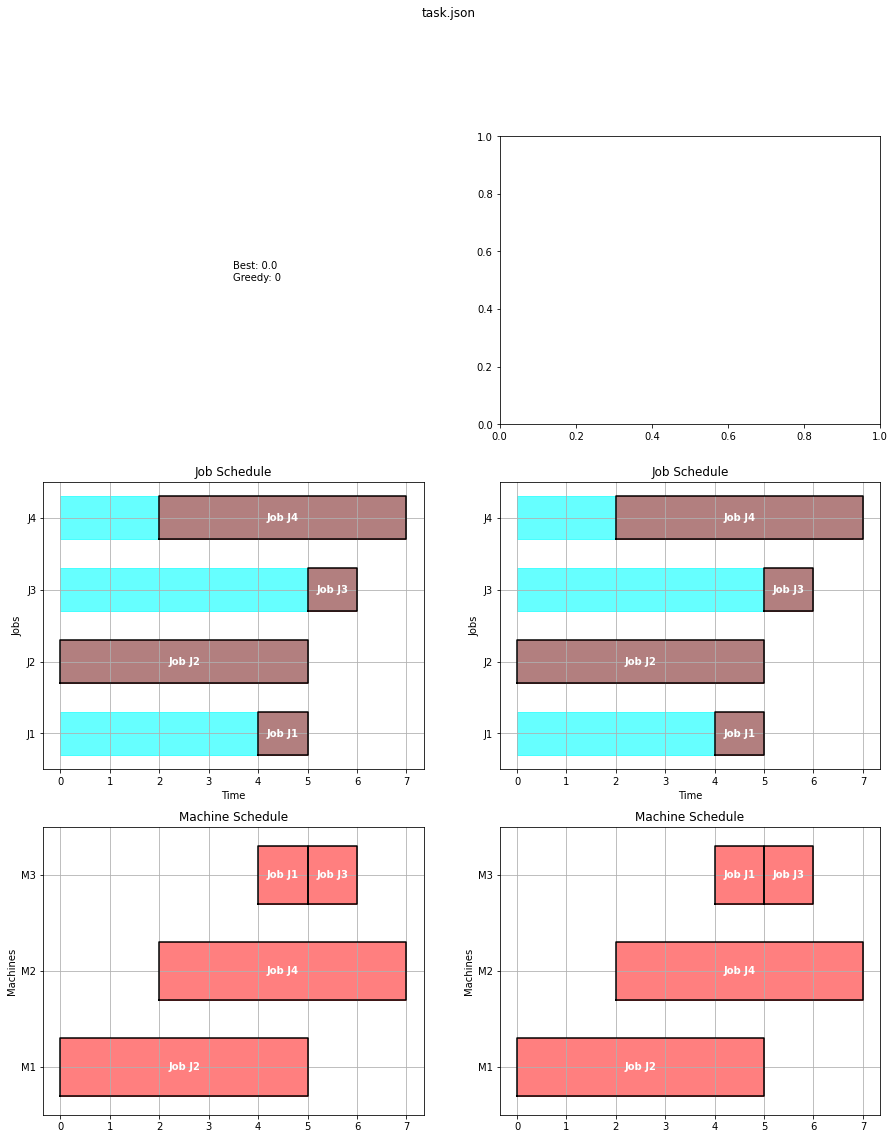

In [149]:
# WriteJson(script.create_task(6, 3, 5, 1, 0, 7))
Test("task.json")

(0.0, 0)

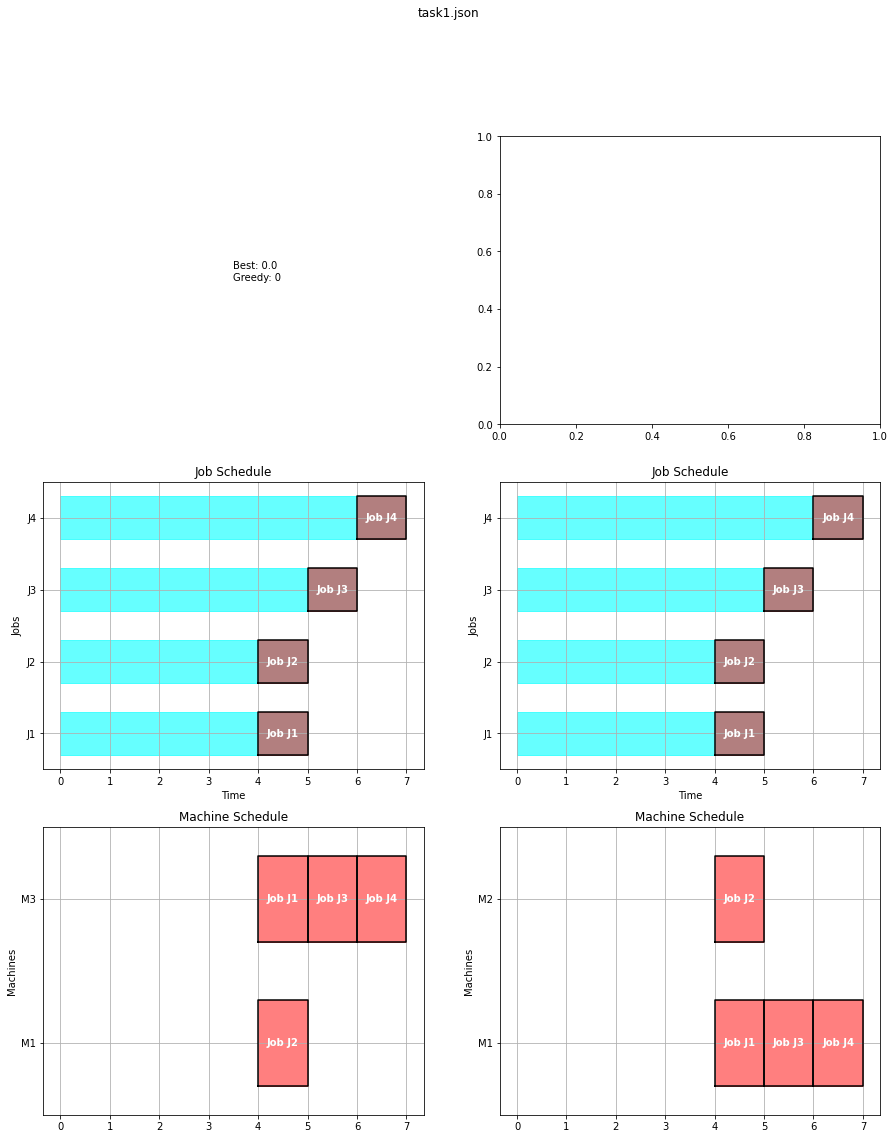

In [150]:
Test("task1.json")

(0.0, 2)

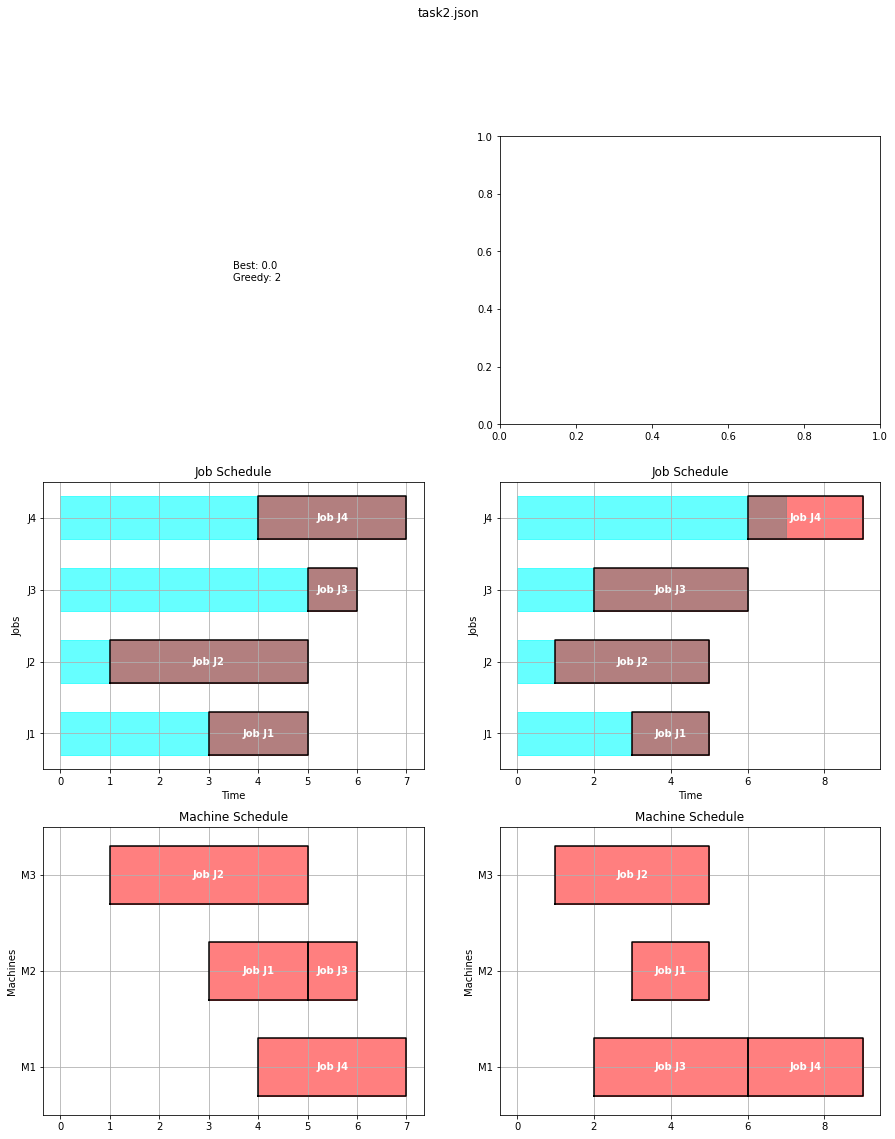

In [151]:
Test("task2.json")

(12.0, 14)

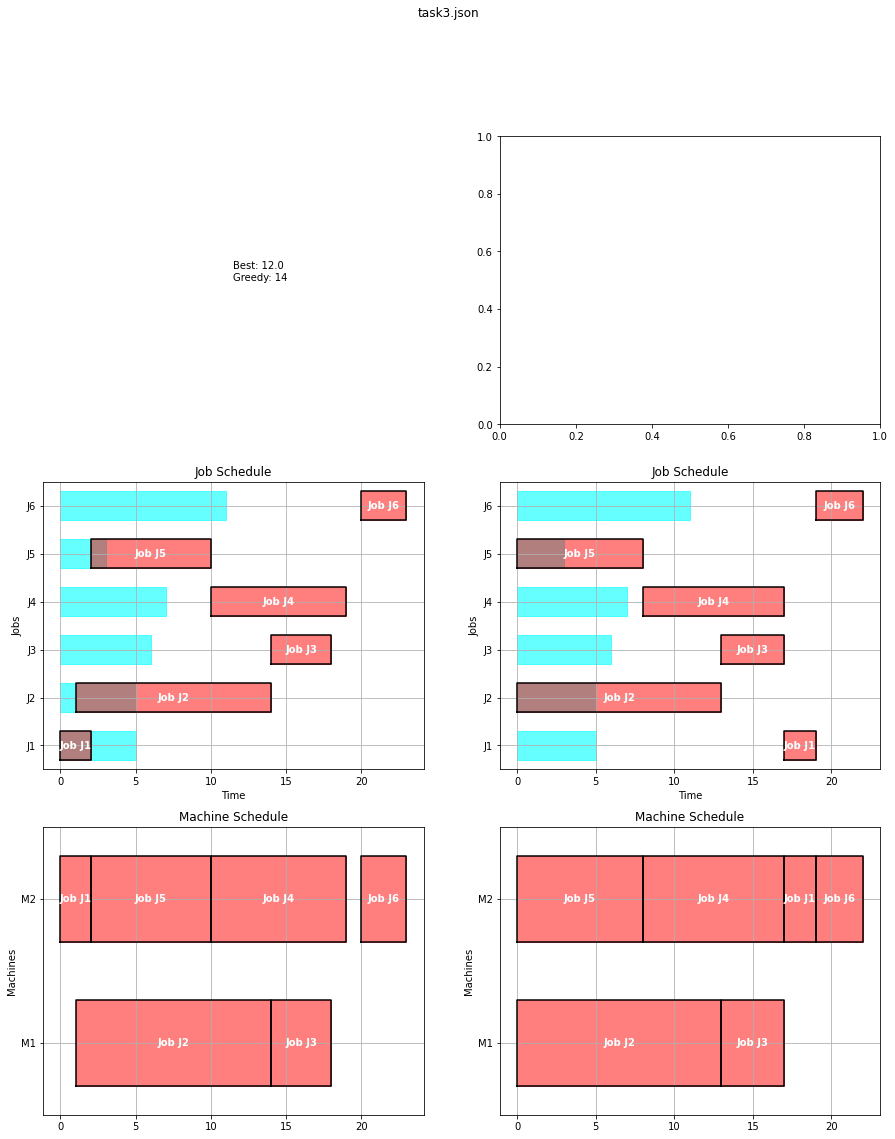

In [152]:
Test("task3.json")